# California Housing Price Prediction

### Importing Necessary Libraries and Utilities

In [1]:
# Data Wrangling Libraries
import numpy as np
import pandas as pd

# Data Visualizing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Utility
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Classifying Algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

Reading and Loading the data for processing 

In [2]:
# Add both training and testing data
data = pd.read_csv('data/housing/housing.csv')
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


Remove all Duplicate Instances from our data

In [3]:
data.drop_duplicates()
data.shape

(20640, 10)

In [4]:
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Gaining a simple overview of our dataset using Histograms

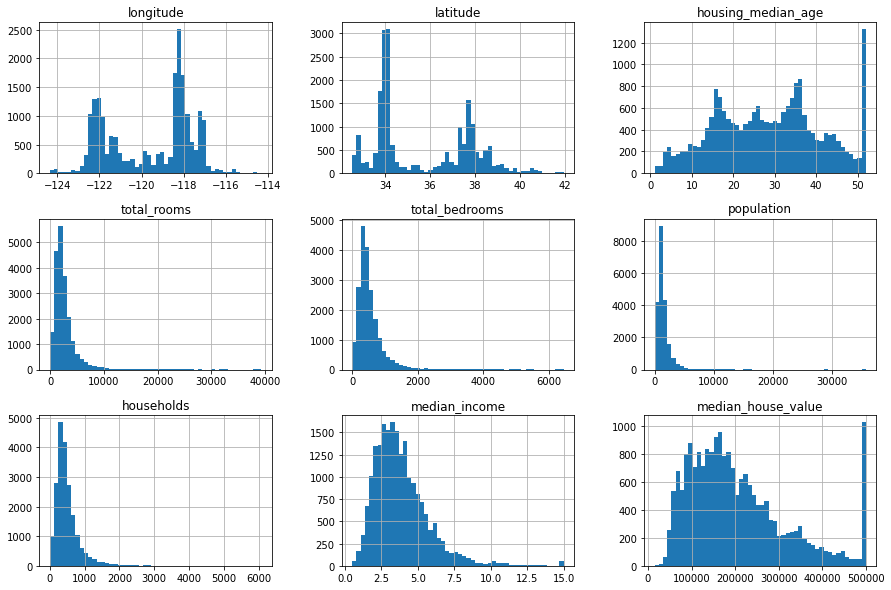

In [5]:
_ = data.hist(bins=50, figsize=(15,10))

Find out all null/missing values within our dataset. We can see that the `total_bedroom` column has multiple missing instances. We will be imputing values into it soon.

In [6]:
print('Null Values:')
print(data.isnull().sum())
print()
print('rows x cols =', data.shape)
print('number of duplicate rows:', data.duplicated().sum())

Null Values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

rows x cols = (20640, 10)
number of duplicate rows: 0


### Data Exploration & Analysis

Scatter plot of the data to show the Latitude and Longitude of the houses

Text(0.5, 1.0, 'Distribution of households')

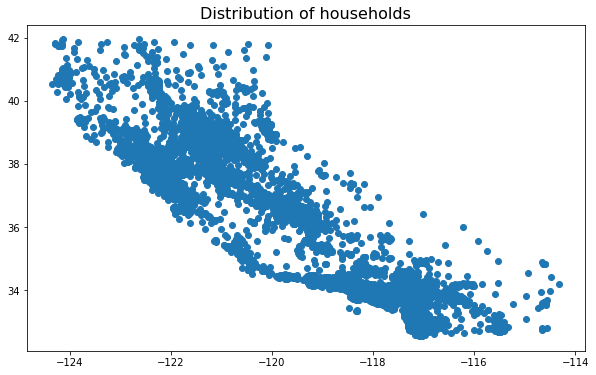

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(x=data['longitude'],y=data['latitude'])
plt.title("Distribution of households",size=16)


Now with the density of the houses within the given areas

Text(0.5, 1.0, 'Distribution of households')

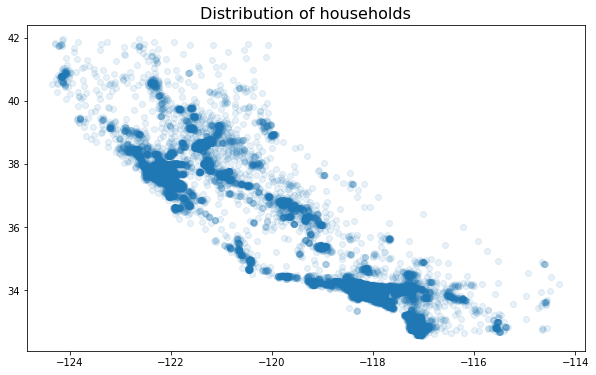

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(x=data['longitude'],y=data['latitude'],alpha=0.1)
plt.title("Distribution of households",size=16)

Now viewing this on a heat map of California

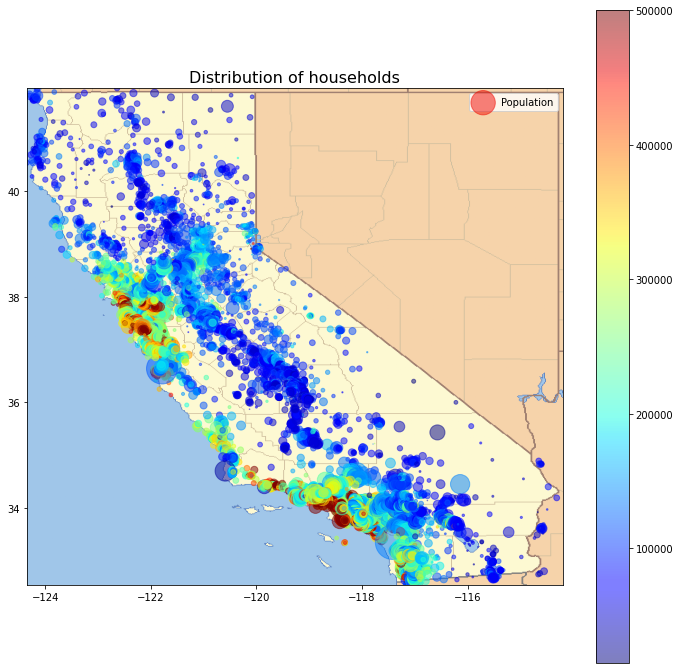

In [9]:
plt.figure(figsize=(12,12))
img=plt.imread('img/california.png')
plt.imshow(img,zorder=0,extent=[-124.35,-114.2,32.54,41.95])

plt.scatter(x=data['longitude'],y=data['latitude'],alpha=0.5,s=data['population']/30,c=data['median_house_value'],
            cmap=plt.get_cmap("jet"),zorder=1,label='Population')
plt.colorbar()
plt.title("Distribution of households",size=16)
plt.legend()

Now analyzing the correlation between the various data columns within our dataset.

<AxesSubplot:>

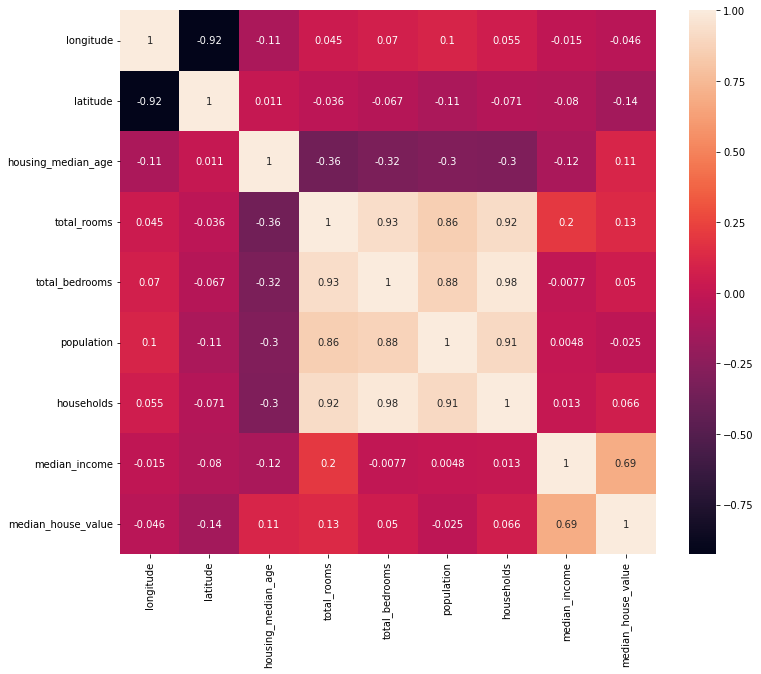

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, ax=ax)

### Data Cleaning

First we will be changing the `ocean_proximity` data into something that is more easily understandible by machines. 

In [11]:
print('Unique entries in Ocean Proximity Column:', data['ocean_proximity'].unique())

Unique entries in Ocean Proximity Column: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [12]:
data.replace({'ocean_proximity': {'NEAR BAY':0, '<1H OCEAN':1, 'INLAND': 2, 'NEAR OCEAN': 3, 'ISLAND': 4}}, inplace=True)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0


We will now be imputing values into our missing `total_bedrooms` entries. We will be replacing the null and missing values with the sample median.

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_vals = imputer.fit_transform(data)
data = pd.DataFrame(columns=data.columns, data=data_vals)
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2.0


### Model Training & Testing

Seperating the data into a training and testing set with 80/20 ratio.

In [14]:
# Seperating Training data & Testing data
train, test = train_test_split(data, train_size=0.8, random_state=1, shuffle=True)

# Seperating the target from the features
train_x = train.drop('median_house_value', axis=1)
train_y = train['median_house_value']

test_x = test.drop('median_house_value', axis=1)
test_y = test['median_house_value']

* **Linear Regression**:

In [15]:
linear_regressor = LinearRegression()
linear_regressor.fit(train_x, train_y)

f'Linear Regression Classifier Test Accuracy = {linear_regressor.score(test_x, test_y) * 100:0.2f}%'

'Linear Regression Classifier Test Accuracy = 62.86%'

* **K-Nearest Neighbors Regression**:

In [16]:
knn_regressor = KNeighborsRegressor(n_neighbors=10)
knn_regressor.fit(train_x, train_y)

f'KNN Regressor Test Accuracy = {knn_regressor.score(test_x, test_y) * 100:0.2f}%'

'KNN Regressor Test Accuracy = 28.62%'

* **Decision Tree Regression**:

In [17]:
dt_regressor = DecisionTreeRegressor(criterion='squared_error')
dt_regressor.fit(train_x, train_y)

f'Decision Tree Regressor Test Accuracy = {dt_regressor.score(test_x, test_y) * 100:0.2f}%'

'Decision Tree Regressor Test Accuracy = 63.92%'

* **Random Forest Regression**:

In [18]:
rnd_forest_regressor = RandomForestRegressor(criterion='poisson')
rnd_forest_regressor.fit(train_x, train_y)

f'Random Forest Regressor Test Accuracy = {rnd_forest_regressor.score(test_x, test_y) * 100:0.2f}%'

'Random Forest Regressor Test Accuracy = 81.35%'

### Concluding Statemennts

Most of our Regression Models give really poor performance with the exception of the Random Forest Algorithm. Hence it is the selected algorithm for predicting instances similar to this dataset.